In [ ]:
pip install fastquant

In [ ]:
import backtrader as bt

In [ ]:
from fastquant import backtest,get_crypto_data
import numpy as np

In [ ]:
df = get_crypto_data("BTCUSDT",start_date='2021-01-01',end_date='2021-12-08', time_resolution='1h')

In [ ]:
df

,open,high,low,close,volume
dt,,,,,
2020-12-31 19:00:00,28872.24,29000.00,28742.41,28897.83,2293.821339
2020-12-31 20:00:00,28897.84,29139.65,28862.00,29126.70,1936.480299
2020-12-31 21:00:00,29126.71,29169.55,28900.79,28966.36,2524.473111
2020-12-31 22:00:00,28966.36,29143.73,28910.19,29100.84,1438.506326
2020-12-31 23:00:00,29100.83,29110.35,28780.00,28923.63,1976.419299
...,...,...,...,...,...
2021-12-07 20:00:00,50884.49,51006.20,50150.00,50441.59,2194.520910
2021-12-07 21:00:00,50441.59,50856.46,50358.99,50489.92,1468.150880
2021-12-07 22:00:00,50489.93,50626.43,50039.74,50245.25,1362.131770


In [ ]:
import matplotlib.pyplot as pl
pl.style.use("default")

In [ ]:
import backtrader as bt
import backtrader.analyzers as btanalyzers

In [ ]:
#conversion line
df['Tenkan_sen'] = (df['high'].rolling(window=9).mean() + df['low'].rolling(window=9).mean())/2

In [ ]:
# Base line
df['Kijun_sen'] = (df['high'].rolling(window=26).mean() + df['low'].rolling(window=26).mean())/2

In [ ]:
df['Senkou_Span_A'] = (df['Tenkan_sen'] + df['Kijun_sen'])/2

In [ ]:
df['Senkou_Span_B'] = (df['high'].rolling(window=52).mean() + df['low'].rolling(window=52).mean())/2

In [ ]:
# Lagging period
df['Chikou_Span'] = df['close'].rolling(window=26).mean()

In [ ]:
df.tail()

,open,high,low,close,volume,Tenkan_sen,Kijun_sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span
dt,,,,,,,,,,
2021-12-07 20:00:00,50884.49,51006.20,50150.00,50441.59,2194.52091,51107.528333,50806.014423,50956.771378,49731.638942,50796.493462
2021-12-07 21:00:00,50441.59,50856.46,50358.99,50489.92,1468.15088,51055.440000,50859.641346,50957.540673,49765.546731,50849.836538
2021-12-07 22:00:00,50489.93,50626.43,50039.74,50245.25,1362.13177,50987.387778,50911.146538,50949.267158,49787.179808,50904.111538
2021-12-07 23:00:00,50245.25,50710.99,50141.60,50588.95,828.39608,50905.761111,50937.736346,50921.748729,49820.295000,50924.485769
2021-12-08 00:00:00,50588.95,50744.17,50319.49,50722.23,1065.20082,50782.526667,50940.150577,50861.338622,49853.997500,50923.805769


In [ ]:
from fastquant import CustomStrategy, BaseStrategy
from fastquant.indicators import MACD, CrossOver 
from fastquant.indicators.custom import CustomIndicator


# Create a subclass of the BaseStrategy, We call this MAMAStrategy (MACD + ALMA)
class MAMAStrategy(BaseStrategy):
    
    params = (
        ("Tenkan_sen", "Tenkan_sen"),   # name for the ALMA column from the dataframe
        ("Kijun_sen", "Kijun_sen"),  
        ("Senkou_Span_A", 'Senkou_Span_A'),  # period for the MACD
        ("Senkou_Span_B", 'Senkou_Span_B'),
        ("Chikou_Span","Chikou_Span")
    )

    def __init__(self):
        # Initialize global variables
        super().__init__()
        
        self.Tenkan_sen = self.params.Tenkan_sen
        self.Kijun_sen = self.params.Kijun_sen
        self.Senkou_Span_A = self.params.Senkou_Span_A
        self.Senkou_Span_B = self.params.Senkou_Span_B
        self.Chikou_Span = self.params.Chikou_Span
        
        # Set ALMA indicator from the alma column of data
        self.Tenkan_sen = CustomIndicator(
            self.data, custom_column=self.Tenkan_sen,
        )
        self.Kijun_sen = CustomIndicator(
            self.data, custom_column=self.Kijun_sen,
        )
        self.Senkou_Span_A = CustomIndicator(
            self.data, custom_column=self.Senkou_Span_A,
        )
        self.Senkou_Span_B = CustomIndicator(
            self.data, custom_column=self.Senkou_Span_B,
        )
        self.Chikou_Span = CustomIndicator(
            self.data, custom_column=self.Chikou_Span,
        )
        

        print("===Strategy level arguments===")
        print("PARAMS: ", self.params)
        

    # Buy when the custom indicator is below the lower limit, and sell when it's above the upper limit
    def buy_signal(self):
        buy =  self.Senkou_Span_A[0] > self.Senkou_Span_B[0]    # Close is above ALMA
        
        
        return buy 
    def sell_signal(self):
        sell = self.Senkou_Span_A[0] < self.Senkou_Span_B[0]

        return sell 

Starting Portfolio Value: 100000.00
2021-12-08T00:00:00, ===Global level arguments===
2021-12-08T00:00:00, init_cash : 100000
2021-12-08T00:00:00, buy_prop : 1
2021-12-08T00:00:00, sell_prop : 1
2021-12-08T00:00:00, commission : 0
2021-12-08T00:00:00, stop_loss : 0
2021-12-08T00:00:00, stop_trail : 0
2021-12-08T00:00:00, take_profit : 0
===Strategy level arguments===
PARAMS:  <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BaseStrategy_MAMAStrategy1 object at 0x000002BA76C2BCA0>
2021-12-08T00:00:00, Final Portfolio Value: 135799.61201804312
2021-12-08T00:00:00, Final PnL: 35799.61
Time used (seconds): 5.28836989402771
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['MAMAStrategy']
**************************************************
--------------------------------------------------
Strategy Parameters	init_cash:100000	buy_prop:1	sell_prop:1	fractional:True	commission:0	stop_loss:0	stop_trail:0	take_pro

<IPython.core.display.Javascript object>


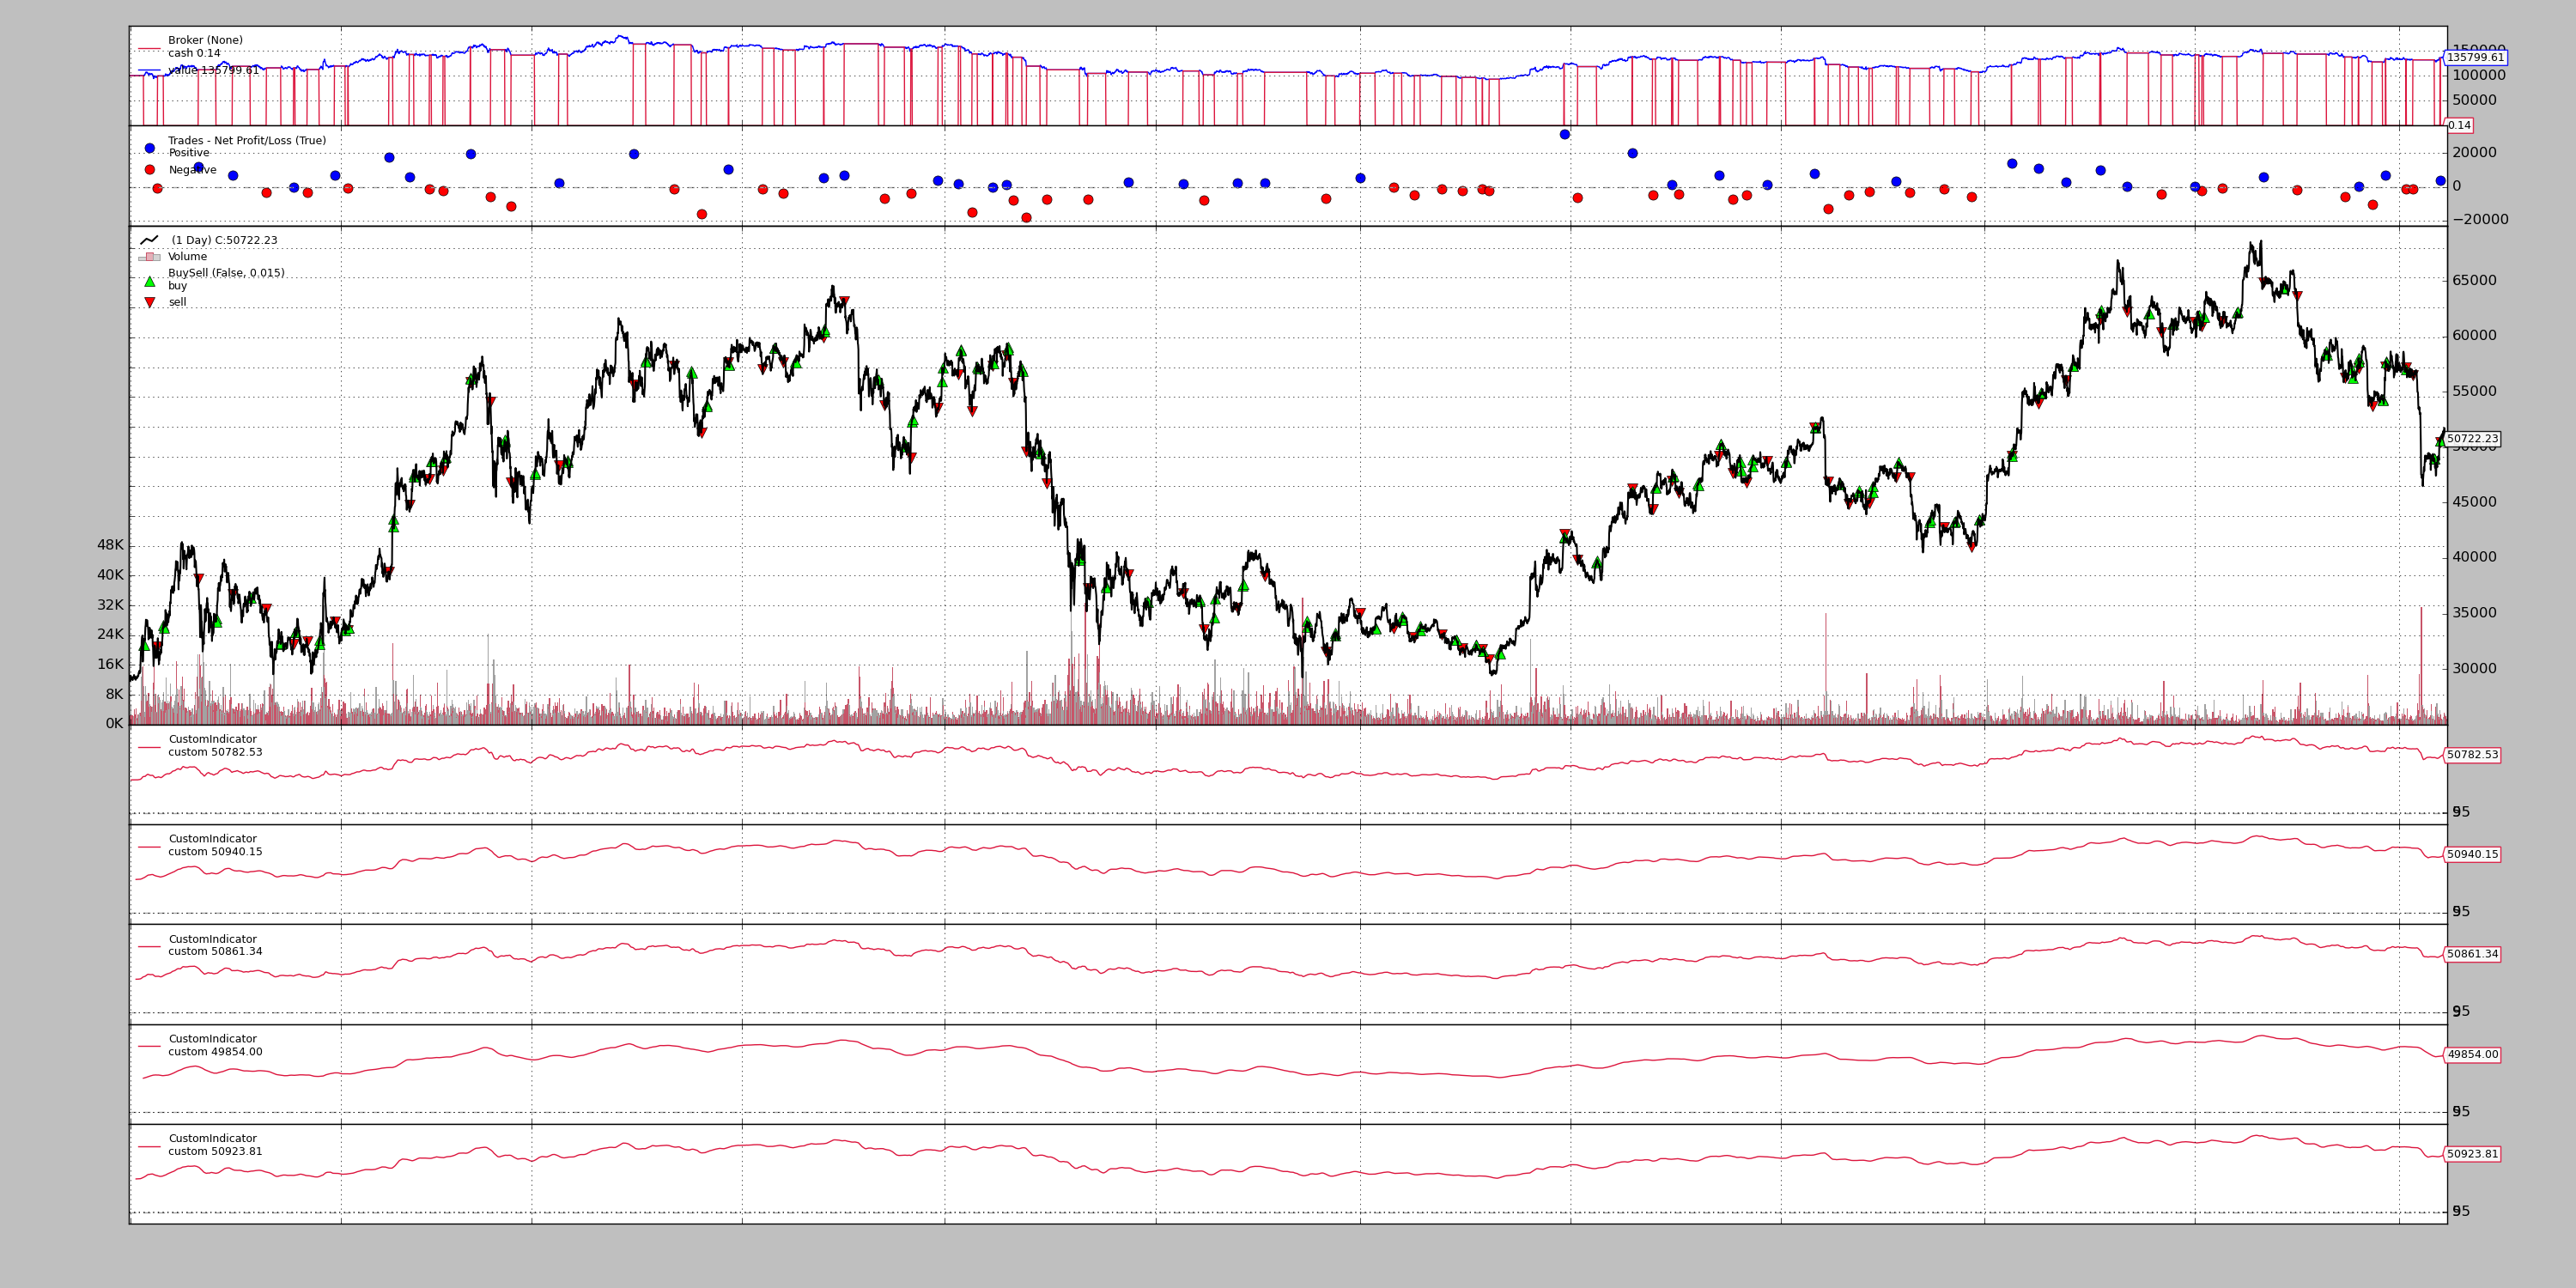

In [ ]:
results,history = backtest(MAMAStrategy, df , init_cash=100000, verbose=True, return_history=True, fractional=True)

In [ ]:
results

,strat_id,init_cash,buy_prop,sell_prop,fractional,commission,stop_loss,stop_trail,take_profit,execution_type,...,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,True,0,0,0,0,close,...,38,46,6947.490268,6.94749,-4966.081207,-4.966081,31427.467826,31.427468,-17927.454981,-17.927455


In [ ]:
results.columns

Index(['strat_id', 'init_cash', 'buy_prop', 'sell_prop', 'fractional',
       'commission', 'stop_loss', 'stop_trail', 'take_profit',
       'execution_type', 'channel', 'symbol', 'allow_short', 'short_max',
       'add_cash_amount', 'add_cash_freq', 'invest_div', 'Tenkan_sen',
       'Kijun_sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span', 'rtot',
       'ravg', 'rnorm', 'rnorm100', 'len', 'drawdown', 'moneydown', 'max',
       'maxdrawdown', 'maxdrawdownperiod', 'sharperatio', 'pnl', 'final_value',
       'total', 'win_rate', 'won', 'lost', 'won_avg', 'won_avg_prcnt',
       'lost_avg', 'lost_avg_prcnt', 'won_max', 'won_max_prcnt', 'lost_max',
       'lost_max_prcnt'],
      dtype='object')

In [ ]:
history['orders']

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,,2021-01-02 23:00:00,buy,32145.66,3.107732,99900.099900,0.0,0.000000
1,0,,2021-01-03 00:00:00,buy,32178.33,0.003101,99.800300,0.0,0.000000
2,0,,2021-01-05 00:00:00,sell,31988.71,-3.110834,99999.900200,0.0,-488.346657
3,0,,2021-01-05 21:00:00,buy,33969.17,2.926543,99412.241102,0.0,0.000000
4,0,,2021-01-05 22:00:00,buy,33699.63,0.002947,99.312928,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
247,0,,2021-12-06 04:00:00,buy,49018.47,2.684857,131607.601652,0.0,0.000000
248,0,,2021-12-06 05:00:00,buy,48979.66,0.002684,131.476126,0.0,0.000000
249,0,,2021-12-07 00:00:00,sell,50441.92,-2.687542,131739.077778,0.0,3825.685404
250,0,,2021-12-07 01:00:00,buy,50634.58,2.674644,135429.465193,0.0,0.000000


In [ ]:
results[['maxdrawdown', 'maxdrawdownperiod', 'sharperatio', 'pnl', 'win_rate']]

,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,win_rate
0,48.354009,269,0.944133,35799.61,0.447059
